# **Multi-label Modelling - BERT**

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Declaring Variables

In [ ]:
# experiment number
experiment_number = 2
iteration_number = 4

# bank names, topic dictionary, and cluster numbers
# bank_names = ["barclays", "hsbc", "lloyds", "monzo", "n26", "natwest", "revolut", "santander", "starling", "wise"]
topic_dict = {-1:"noise", 0:"crypto", 1:"stocks", 2:"app interface", 3:"bank subscription plans", 
              4:"usage abroad", 5:"refunds", 6:"customer_service", 7:"account issues",
              8:"tedious paperwork (request of documents)", 
              9:"additional fees (e.g. card delivery and transaction fees)", 
              10:"business accounts", 11:"account verification", 12:"fraudulent transactions", 
              13:"online payments", 14:"frozen account and money holdout", 15:"exchange rates", 16:"transfers", 
              17:"atm withdrawal"}
cluster_numbers = [cluster_number for cluster_number in topic_dict.keys()]
label_list = [f"label_{cluster_number}" for cluster_number in cluster_numbers] # column names

# declaring filepaths
bert_model_filepath = f'model/bert/trained_models/experiment_{experiment_number}/'
bert_results_filepath = f'model/bert/results/experiment_{experiment_number}/'
bert_train_val_test_filepath = f'model/bert/train_validation_test_datasets/experiment_{experiment_number}/'
results_filepath = f'model/random_forest/ovr_applied_entire_dataset_results/iteration_{iteration_number}/'

# BERT hyperparameters
max_len = 512
padding = 'max_length'
batch_size = 16
epochs = 10
learning_rate = 2e-5
dropout_rate = 0.2
hidden_dim = 100

# testing and training split size
train_size = 0.8
split_random_state = 42

freq_threshold = 500
early_stopping_epoch = 3

# Importing Libraries

In [ ]:
pip install smart_open[s3]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
# import numpy as np
import ast
# import boto3
import tempfile
import joblib
from io import StringIO, BytesIO
from transformers import BertTokenizer, BertModel
import tensorflow_hub as hub
import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from io import StringIO, BytesIO
from smart_open import open as smart_open
# from smart_open import open
import json
import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages')
import boto3
import plotly.graph_objects as go
from statistics import mean, median
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sn

In [ ]:
# assigning gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Defining Functions to Save and Load Files

In [ ]:
# saving file
def saving_file(df, filepath, filename):
    
    bucket = 'intelligent-social-media-tracking' # already created on S3
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, filepath + filename).put(Body=csv_buffer.getvalue())

# loading file
def loading_file(filepath, filename, start_col):
    
    bucket = 'intelligent-social-media-tracking'
    data_key = filename
    data_location = 's3://{0}/{1}{2}'.format(bucket, filepath, data_key)
    df = pd.read_csv(data_location).iloc[:, start_col:]
    
    return df

# saving torch model
def saving_torch_model(model, filepath, filename):
    
    bucket = 'intelligent-social-media-tracking'
    key = filepath + filename
    
    s3_client = boto3.client('s3')
    buffer = BytesIO()
    torch.save(model.state_dict(), buffer)
    s3_client.put_object(Bucket=bucket, Key=key, Body=buffer.getvalue())

# loading torch model
def loading_torch_model(model, filepath, filename):
    
    bucket = 'intelligent-social-media-tracking'
    s3_client = boto3.client('s3')   
    key = filepath + filename    
    
    with smart_open(f"s3://{bucket}/{key}", 'rb') as f:
        buffer = BytesIO(f.read())
        model.load_state_dict(torch.load(buffer, map_location='cpu'))
    
    return model

# saving list
def saving_list(list_name, filepath, filename):
    
    bucket = 'intelligent-social-media-tracking'
    s3_resource = boto3.resource('s3')
    object = s3_resource.Object(bucket, filepath + filename)
    object.put(Body=(bytes(json.dumps(list_name, indent=2).encode('UTF-8'))))

# loading list
def loading_list(filepath, filename):
    
    bucket = 'intelligent-social-media-tracking'
    s3_resource = boto3.resource('s3')
    content_object = s3_resource.Object(bucket, filepath + filename)
    file_content = content_object.get()['Body'].read().decode('utf-8')
    json_content = json.loads(file_content)
    
    return json_content

# Loading Datasets

In [ ]:
sentence_embeddings_large_df = loading_file(results_filepath, 'ovr_all_majority_voting_multitagging_noise.csv', 1)
sentence_embeddings_large_df.head(2)

,text,sentences,cleaned_sentences,0,1,2,3,4,5,6,...,multi_tag_array,multitag_combination_prob,multi_tag_prob_array,multi_tag_label_prob,tag_prob_label,tag_prob_label_sorted,tag_prob_label_sorted_multi_class,top_tag_prob_labels,top_topics_list,top_topics_str
0,No customer service. I have been trying to op...,No customer service.,customer service .,-0.044105,0.057150,-0.008763,0.012723,0.006505,0.008021,-0.005559,...,"['0', '0', '0', '0', '0', '0', '0', '1', '0', ...","0.4191,0.0468,0.08460000000000001,0.0663,0.116...","[0.4191, 0.0468, 0.08460000000000001, 0.0663, ...","(['0', '0', '0', '0', '0', '0', '0', '1', '0',...","[('0', 0.4191, -1), ('0', 0.0468, 0), ('0', 0....","[('1', 0.9948, 6), ('0', 0.4191, -1), ('0', 0....","([('1', 0.9948, 6), ('0', 0.4191, -1), ('0', 0...","[('1', 0.9948, 6)]",['customer_service'],customer_service
1,No customer service. I have been trying to op...,I have been trying to open bank accounts for ...,trying open accounts children via video app .,0.030530,0.011607,0.012181,0.015835,0.038889,0.057693,-0.039712,...,"['0', '0', '0', '1', '0', '0', '0', '0', '1', ...","0.4759,0.1319,0.1887,0.5414,0.249,0.2254,0.119...","[0.4759, 0.1319, 0.1887, 0.5414, 0.249, 0.2254...","(['0', '0', '0', '1', '0', '0', '0', '0', '1',...","[('0', 0.4759, -1), ('0', 0.1319, 0), ('0', 0....","[('1', 0.6668000000000001, 7), ('1', 0.5785, 1...","([('1', 0.6668000000000001, 7), ('1', 0.5785, ...","[('1', 0.6668000000000001, 7), ('1', 0.5785, 11)]","['account issues', 'account verification']","account issues, account verification"


# Getting Multitags and Creating Dataframe

In [ ]:
cluster_numbers = [cluster_number for cluster_number in topic_dict.keys()]
# cluster_numbers = cluster_numbers[1:]

df_dict = {"text":sentence_embeddings_large_df.text, "sentences":sentence_embeddings_large_df.sentences, 
           "cleaned_sentences":sentence_embeddings_large_df.cleaned_sentences, "top_tag_prob_labels":sentence_embeddings_large_df.top_tag_prob_labels} 
df = pd.DataFrame(df_dict) # creating new dataframe with the text and multilabel tuples

df["top_tag_prob_labels_arr"] = df["top_tag_prob_labels"].apply(lambda x: ast.literal_eval(x)) # converting string of a list to a list of tuples

# dropping noise from those with multitags and keeping noise if they are single tagged
df["top_tag_prob_labels_arr_no_noise"] = df["top_tag_prob_labels_arr"].apply(lambda x: [tag_prob_label for tag_prob_label in x if ((len(x) == 1) or ((tag_prob_label[2] != -1) and (len(x) > 1)))])

df["multi_tag_arr"] = df["top_tag_prob_labels_arr_no_noise"].apply(lambda x: [1 if cluster_number in [tag_prob_label[2] for tag_prob_label in x] else 0 for cluster_number in cluster_numbers]) # getting array representing the multitags

# topics of each label, stored as an array
df["top_topics_list"] = df["top_tag_prob_labels_arr_no_noise"].apply(lambda x: sorted([topic_dict[tag_prob_label[2]] for tag_prob_label in x]))

# topics of each label as string
df["top_topics_str"] = df["top_topics_list"].apply(lambda x: ", ".join(x))

df["number_of_tags"] = 0
# splitting multilabels into respective columns
for cluster_number in cluster_numbers:
    df[f"label_{cluster_number}"] = df["multi_tag_arr"].apply(lambda x: x[cluster_number + 1]) # getting multitag in a column representation
    df["number_of_tags"] += df[f"label_{cluster_number}"]
    
df.drop(['top_tag_prob_labels', 'top_tag_prob_labels_arr', 'top_tag_prob_labels_arr_no_noise', 'multi_tag_arr'], axis=1, inplace=True) # removing unused columns

df.head(2)

,text,sentences,cleaned_sentences,top_topics_list,top_topics_str,number_of_tags,label_-1,label_0,label_1,label_2,...,label_8,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17
0,No customer service. I have been trying to op...,No customer service.,customer service .,[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,No customer service. I have been trying to op...,I have been trying to open bank accounts for ...,trying open accounts children via video app .,"[account issues, account verification]","account issues, account verification",2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
capped_multitag = 2
num_top_plot = 20
num_multitags = [i for i in range(1, capped_multitag+1)]
all_multitags = []
for num in num_multitags:
    
    num_multitag_df = df.loc[df.loc[:, 'number_of_tags'] == num, :]
    multitag_combinations = list(set(num_multitag_df.loc[:, 'top_topics_str']))
    all_multitags.extend(multitag_combinations)
    combi_count_tuples = [(combi, len(num_multitag_df.loc[num_multitag_df.loc[:, "top_topics_str"] == combi, :])) for combi in multitag_combinations]
    combi_count_tuples_sorted = sorted(combi_count_tuples, key=lambda x: x[1], reverse=True)[:num_top_plot + 1]
    combi_count_tuples_sorted = sorted(combi_count_tuples_sorted, key=lambda x: x[1])
    combi_counts = [combi_tuple[1] for combi_tuple in combi_count_tuples_sorted]
    combi_topics = [combi_tuple[0] for combi_tuple in combi_count_tuples_sorted]
    
    combi_norm_count_tuples = [(combi, len(num_multitag_df.loc[num_multitag_df.loc[:, "top_topics_str"] == combi, :])/len(num_multitag_df)) for combi in multitag_combinations]
    combi_norm_count_tuples_sorted = sorted(combi_norm_count_tuples, key=lambda x: x[1], reverse=True)[:num_top_plot + 1]
    combi_norm_count_tuples_sorted = sorted(combi_norm_count_tuples_sorted, key=lambda x: x[1])
    combi_norm_counts = [combi_tuple[1] for combi_tuple in combi_norm_count_tuples_sorted]
    combi_norm_topics = [combi_tuple[0] for combi_tuple in combi_norm_count_tuples_sorted]
    
    # setting up figure and lists to store buttons
    fig = go.Figure()
    buttons_1 = []
    y_buttons_1 = -0.15
    
    # plotting distribution of clusters
    fig.add_trace(go.Bar(
        x=combi_counts, 
        y=combi_topics,
        visible=True,
        orientation='h'))
    
    # button formatting
    button =  dict(
        args = [{'visible':[True, False]}, 
                {"title": f"Distribution of Unique Label Combinations with {num} labels (Including Noise)", "xaxis_title": "Frequency"}], 
        label = "Raw Frequency",
        method = 'update'
    )            
    buttons_1.append(button)
    
    # plotting normalised distribution of clusters
    fig.add_trace(go.Bar(
        x=combi_norm_counts, 
        y=combi_norm_topics,
        visible=False,
        orientation='h'))
    
    # button formatting
    button =  dict(
        args = [{'visible':[False, True]}, 
                {"title": f"Normalised Distribution of Unique Label Combinations with {num} labels (Including Noise)", "xaxis_title": "Normalised Frequency"}], 
        label = "Normalised Frequency",
        method = 'update'
    )
    buttons_1.append(button)

                 
    # Add dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                type = "buttons",
                direction="right",
                buttons=buttons_1,
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0,
                xanchor="left",
                y=y_buttons_1,
                yanchor="top"
            )
        ]
    )

    fig.update_layout(width=1200, height=800,
        title={
            'text': f"Distribution of Unique Label Combinations with {num} labels",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Frequency",
        yaxis = dict(tickfont = dict(size=15)),
        xaxis = dict(tickfont = dict(size=15)),
        showlegend=False)

    fig.show()
    
    print(f"Total number of unique label combinations with {num} labels: {len(multitag_combinations)}")


Total number of unique label combinations with 1 labels: 19


Total number of unique label combinations with 2 labels: 152


# Dropping Sentences Below Frequency Threshold

In [ ]:
combi_count_tuples = [(combi, len(df.loc[df.loc[:, "top_topics_str"] == combi, :])) for combi in all_multitags]
combi_count_tuples_sorted = sorted(combi_count_tuples, key=lambda x: x[1], reverse=True)
topics_exclude = [count_tuple[0] for count_tuple in combi_count_tuples if count_tuple[1] < freq_threshold]

df_excl = df.copy()
for topic_excl in topics_exclude:
    df_excl = df_excl.drop(df_excl[df_excl.top_topics_str == topic_excl].index).reset_index(drop=True)
df_excl

,text,sentences,cleaned_sentences,top_topics_list,top_topics_str,number_of_tags,label_-1,label_0,label_1,label_2,...,label_8,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17
0,No customer service. I have been trying to op...,No customer service.,customer service .,[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,No customer service. I have been trying to op...,I have been trying to open bank accounts for ...,trying open accounts children via video app .,"[account issues, account verification]","account issues, account verification",2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,No customer service. I have been trying to op...,It is either severely under staffed or not fi...,either severely under staffed not fit purpose .,[usage abroad],usage abroad,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,No customer service. I have been trying to op...,Having tried on numerous occasions and holdin...,having tried numerous occasions holding queue ...,[],,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,No customer service. I have been trying to op...,I am told that I cannot open an account in br...,told cannot open account branch struggling ope...,"[account issues, atm withdrawal]","account issues, atm withdrawal",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217860,I had previously written a good review about t...,For about a MONTH I received no reply.,about month received reply .,[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217861,I had previously written a good review about t...,I emailed them again and this time they replie...,emailed again time replied decided close accou...,[account issues],account issues,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217862,I had previously written a good review about t...,"When asked for an explanation, they would not ...","asked explanation not give beyond saying ""for ...",[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217863,I had previously written a good review about t...,I have no idea what I could have done to cause...,"idea could done cause these ""security issues"" ...","[business accounts, customer_service]","business accounts, customer_service",2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
combi_count_tuples = [(combi, len(df.loc[df.loc[:, "top_topics_str"] == combi, :])) for combi in all_multitags]
combi_count_tuples_sorted = sorted(combi_count_tuples, key=lambda x: x[1], reverse=True)
topics_exclude = [count_tuple[0] for count_tuple in combi_count_tuples if count_tuple[1] < freq_threshold]

df_excl = df.copy()
for topic_excl in topics_exclude:
    df_excl = df_excl.drop(df_excl[df_excl.top_topics_str == topic_excl].index).reset_index(drop=True)
df_excl

,text,sentences,cleaned_sentences,top_topics_list,top_topics_str,number_of_tags,label_-1,label_0,label_1,label_2,...,label_8,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17
0,No customer service. I have been trying to op...,No customer service.,customer service .,[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,No customer service. I have been trying to op...,I have been trying to open bank accounts for ...,trying open accounts children via video app .,"[account issues, account verification]","account issues, account verification",2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,No customer service. I have been trying to op...,It is either severely under staffed or not fi...,either severely under staffed not fit purpose .,[usage abroad],usage abroad,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,No customer service. I have been trying to op...,Having tried on numerous occasions and holdin...,having tried numerous occasions holding queue ...,[],,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,No customer service. I have been trying to op...,I am told that I cannot open an account in br...,told cannot open account branch struggling ope...,"[account issues, atm withdrawal]","account issues, atm withdrawal",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217860,I had previously written a good review about t...,For about a MONTH I received no reply.,about month received reply .,[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217861,I had previously written a good review about t...,I emailed them again and this time they replie...,emailed again time replied decided close accou...,[account issues],account issues,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217862,I had previously written a good review about t...,"When asked for an explanation, they would not ...","asked explanation not give beyond saying ""for ...",[customer_service],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217863,I had previously written a good review about t...,I have no idea what I could have done to cause...,"idea could done cause these ""security issues"" ...","[business accounts, customer_service]","business accounts, customer_service",2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
for num in num_multitags:
    
    num_multitag_df_excl = df_excl.loc[df_excl.loc[:, 'number_of_tags'] == num, :]
    multitag_combinations = list(set(num_multitag_df_excl.loc[:, 'top_topics_str']))
    combi_count_tuples = [(combi, len(num_multitag_df_excl.loc[num_multitag_df_excl.loc[:, "top_topics_str"] == combi, :])) for combi in multitag_combinations]
    combi_count_tuples_sorted = sorted(combi_count_tuples, key=lambda x: x[1], reverse=True)[:num_top_plot + 1]
    combi_count_tuples_sorted = sorted(combi_count_tuples_sorted, key=lambda x: x[1])
    combi_counts = [combi_tuple[1] for combi_tuple in combi_count_tuples_sorted]
    combi_topics = [combi_tuple[0] for combi_tuple in combi_count_tuples_sorted]
    
    combi_norm_count_tuples = [(combi, len(num_multitag_df_excl.loc[num_multitag_df_excl.loc[:, "top_topics_str"] == combi, :])/len(num_multitag_df_excl)) for combi in multitag_combinations]
    combi_norm_count_tuples_sorted = sorted(combi_norm_count_tuples, key=lambda x: x[1], reverse=True)[:num_top_plot + 1]
    combi_norm_count_tuples_sorted = sorted(combi_norm_count_tuples_sorted, key=lambda x: x[1])
    combi_norm_counts = [combi_tuple[1] for combi_tuple in combi_norm_count_tuples_sorted]
    combi_norm_topics = [combi_tuple[0] for combi_tuple in combi_norm_count_tuples_sorted]
    
    print(f"Total number of unique label combinations with {num} labels: {len(multitag_combinations)}")


Total number of unique label combinations with 1 labels: 16
Total number of unique label combinations with 2 labels: 41


# Split Into Testing and Training

In [ ]:
train_val_df, test_df = train_test_split(df_excl, train_size=train_size, random_state=split_random_state, stratify=df_excl["top_topics_str"])
train_val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

saving_file(train_val_df, bert_train_val_test_filepath, 'bert_train_valid.csv')
saving_file(test_df, bert_train_val_test_filepath, 'bert_test.csv')

In [ ]:
train_val_df = loading_file(bert_train_val_test_filepath, 'bert_train_valid.csv', 1)
test_df = loading_file(bert_train_val_test_filepath, 'bert_test.csv', 1)

# Downsampling Populated Labels

In [ ]:
# getting counts for each 1-label and 2-label combination
all_counts = []
all_topics = []

for num in num_multitags:
    
    num_multitag_df = train_val_df.loc[train_val_df.loc[:, 'number_of_tags'] == num, :]
    multitag_combinations = list(set(num_multitag_df.loc[:, 'top_topics_str'])) # getting unique label combinations
    
    combi_count_tuples = [(combi, len(num_multitag_df.loc[num_multitag_df.loc[:, "top_topics_str"] == combi, :])) for combi in multitag_combinations]
    combi_count_tuples_sorted = sorted(combi_count_tuples, key=lambda x: x[1], reverse=True)
    combi_counts = [combi_tuple[1] for combi_tuple in combi_count_tuples_sorted]
    combi_topics = [combi_tuple[0] for combi_tuple in combi_count_tuples_sorted]
    all_counts.extend(combi_counts)
    all_topics.extend(combi_topics)

all_counts_sorted = sorted(all_counts) # sorting counts
idx_list = [i for i in range(len(all_counts_sorted)) for _ in range(all_counts_sorted[i])]
median_idx = int(median(idx_list))
median_counts = all_counts_sorted[median_idx] # median of all counts
mean_counts = mean(all_counts_sorted) # mean of all counts

print(f"Median Counts = {median_counts}")
print(f"Mean Counts = {mean_counts}")

# down-sampling noise to median cluster size
# getting labels which need to be downsampled
to_downsample_topics = [all_topics[all_counts.index(counts)] for counts in all_counts if counts > median_counts] # getting index of counts and topics which exceed median count
train_val_resample_df = train_val_df.copy()

print(f"\nOriginal size of training and validation dataframe: {len(train_val_df)}")

for topic in to_downsample_topics:
    
    train_val_downsample_df = train_val_resample_df.loc[train_val_resample_df.loc[:, "top_topics_str"] == topic, :] # label combinations to downsample
    train_val_resample_df = train_val_resample_df.loc[train_val_resample_df.loc[:, "top_topics_str"] != topic, :] # all topics excluding those which needs to be downsampled
    
    print(f"Number of sentences from topic: {len(train_val_downsample_df)}")
    
    train_val_resample_topic_df = (resample(train_val_downsample_df, n_samples=int(median_counts))) # resampling
    train_val_resample_df = pd.concat([train_val_resample_df, train_val_resample_topic_df]) # concatenating to the dataframe which removed the label combination
    train_val_resample_df.reset_index(inplace=True, drop=True)

    print(f"Size of training and validation dataframe after downsampling {topic}: {len(train_val_resample_df)}")
    

train_df, val_df = train_test_split(train_val_resample_df, train_size=train_size, random_state=split_random_state, stratify=train_val_resample_df["top_topics_str"])
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

saving_file(train_df, bert_train_val_test_filepath, 'bert_train.csv')
saving_file(val_df, bert_train_val_test_filepath, 'bert_valid.csv')

Median Counts = 14846
Mean Counts = 3010.754385964912

Original size of training and validation dataframe: 174292
Number of sentences from topic: 59542
Size of training and validation dataframe after downsampling customer_service: 129596
Number of sentences from topic: 16471
Size of training and validation dataframe after downsampling business accounts: 127971


# BERT Multi-label Model Development

Code heavily inspired from the following links:

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi%20Label%20Text%20Classification%20using%20BERT%20PyTorch/bert_multilabel_pytorch_standard.ipynb

https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

# Loading BERT Pre-Processing Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Creating Dataset Class

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.title = df["sentences"]
        self.targets = df[label_list].values
    
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, index):
            
        title = self.title[index]

        # scope of encode_plus:
        # 1.splits the sentences into tokens 
        # 2.adds the classification and seperator tokens 
        # 3. maps the tokens to their IDs 
        # 4. pads or truncates all sentences to the same length (max_length) 
        # 5. creates the attention masks which explicitly differentiates real tokens from pad tokens.
        inputs = self.tokenizer.encode_plus(
            title, 
            max_length = self.max_len, 
            padding=padding, 
            return_token_type_ids=True, 
            truncation=True, 
            return_attention_mask=True, 
            return_tensors='pt'
        )

        return {'input_ids': inputs['input_ids'].flatten(), 
            'attention_mask': inputs['attention_mask'].flatten(), 
            'token_type_ids': inputs['token_type_ids'].flatten(), 
            'targets': torch.tensor(self.targets[index])}        

# Wrapping in Dataset and DataLoader Wrapper

In [ ]:
# loading training and validation dataset
train_df = loading_file(bert_train_val_test_filepath, 'bert_train.csv', 1)
val_df = loading_file(bert_train_val_test_filepath, 'bert_valid.csv', 1)

# Dataset class to encode text and targets
train_set = Dataset(train_df, tokenizer, max_len)
valid_set = Dataset(val_df, tokenizer, max_len)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True) # training set
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size) # validation set

# Initialising Model

In [ ]:
# BERT model
class BERTClass(torch.nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(BERTClass, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True) # first layer
        self.linear1 = torch.nn.Linear(768, hidden_dim) # additional hidden layer layer
        self.dropout = torch.nn.Dropout(dropout_rate) 
        self.linear2 = torch.nn.Linear(hidden_dim, num_labels) # final layer of hidden dimensions -> number of labels 
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids=input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )

        output = torch.mean(output.last_hidden_state, dim=1)
        output = torch.nn.functional.relu(self.linear1(output))
        output = self.dropout(output)
        output = torch.sigmoid(self.linear2(output))
#         output_dropout = self.dropout(output.pooler_output) # dropout from classification ([CLS]) tensor
#         output = self.linear(output_dropout) # using classification tensor to predict multilabels
        return output

# defining loss function
def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets)
    
model = BERTClass(hidden_dim, len(cluster_numbers))
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=learning_rate)

# Model Training

## Training Function

In [ ]:
# function to train the model
def train(train_dataloader):

    model.train() # set to train

    # initialising training loss and accuracy
    train_loss = 0 

    # empty list to save model predictions
    train_preds=[]
    train_targets = []

    for step, batch in enumerate(train_dataloader):   
        
        # getting ids, mask, token_type_ids and targets
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        target = batch['targets'].to(device, dtype = torch.float)

        model.zero_grad()
        
        predicted = model(ids, mask, token_type_ids) # model predictions for current batch
        loss = loss_fn(predicted, target) # calculating loss between predicted and target
        
        train_loss += loss.item() # add on to the total loss
        loss.backward() # backward pass - back propagation
        
        # progress update after every 5000 batches.
        if step % 5000 == 0 and not step == 0:
            print(f'---------Batch {step} of {len(train_dataloader)}---------')

#         optimizer.zero_grad() # clearing prior calculated gradients
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() # update parameters

        predicted = predicted.detach().cpu().numpy() # push predicted from gpu to cpu
        train_preds.append(predicted) # append the model predictions
        
        target = target.detach().cpu().numpy()
        train_targets.append(target) # appending targets

    avg_loss = train_loss / len(train_dataloader) # compute the training loss of the epoch
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    train_preds  = np.concatenate(train_preds, axis=0)
    train_targets  = np.concatenate(train_targets, axis=0)

    #returns the loss and predictions
    return avg_loss, train_preds, train_targets

## Evaluation Function

In [ ]:
# function for evaluating the model
def evaluate(val_dataloader):

    print("\nEvaluating...")

    model.eval() # evaluation mode

    valid_loss = 0 # initialising validation loss

    # empty list to save the model predictions
    valid_preds = []
    valid_targets = []

    with torch.no_grad():
        # iterate over batches
        for step, batch in enumerate(val_dataloader):
            
            # getting ids, mask, token_type_ids, targets and predicted
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            target = batch['targets'].to(device, dtype = torch.float)
            
            predicted = model(ids, mask, token_type_ids) # model predictions for current batch
            loss = loss_fn(predicted, target) # calculating loss
            
            valid_loss += loss.item() # aggregating loss

            predicted = predicted.detach().cpu().numpy()
            valid_preds.append(predicted) # appending predictions
            
            target = target.detach().cpu().numpy()
            valid_targets.append(target) # appending targets
            

        # compute the validation loss of the epoch
        avg_loss = valid_loss / len(val_dataloader) 

        # reshape the predictions in form of (number of samples, no. of classes)
        valid_preds  = np.concatenate(valid_preds, axis=0)
        valid_targets  = np.concatenate(valid_targets, axis=0)

    return avg_loss, valid_preds, valid_targets

## Accuracy Function

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] ) # get index of 1's for 
        set_pred = set( np.where(y_pred[i])[0] ) # get index of 1's for predictions
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

## Training and Evaluation Loop

In [ ]:
def train_eval_model(n_epochs, train_dataloader, val_dataloader, optimizer):
    
    train_losses = []
    valid_losses = []
    
    train_accuracy = []
    valid_accuracy = []
    
    train_hamming = []
    valid_hamming = []
    
    best_valid_loss = float('inf')
    
    for epoch in range(1, n_epochs + 1):
        
        print(f'Epoch {epoch} / {n_epochs}')
        train_loss, train_preds, train_targets = train(train_dataloader) # train model
        valid_loss, valid_preds, valid_targets = evaluate(val_dataloader) # evaluate model

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            saving_torch_model(model, bert_model_filepath, f'bert_epoch_{epoch}.pt')

        # rounding predictions
        train_preds_round = np.around(train_preds)
        valid_preds_round = np.around(valid_preds)
        
        # getting accuracies
        train_hamming_acc = hamming_score(train_targets, train_preds_round)
        valid_hamming_acc = hamming_score(valid_targets, valid_preds_round)
        train_reg_acc = accuracy_score(train_targets, train_preds_round)
        valid_reg_acc = accuracy_score(valid_targets, valid_preds_round)
        
        # printing results
        print(f'\nTraining Loss: {train_loss}')
        print(f'Validation Loss: {valid_loss}\n')
        print(f'\nTraining Hamming Accuracy: {train_hamming_acc}')
        print(f'Validation Hamming Accuracy: {valid_hamming_acc}\n')
        print(f'\nTraining Sklearn Accuracy: {train_reg_acc}')
        print(f'Validation Sklearn Accuracy: {valid_reg_acc}\n')
        
        # losses
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # hamming accuracy
        train_hamming.append(train_hamming_acc)
        valid_hamming.append(valid_hamming_acc)
        
        # sklearn accuracy
        train_accuracy.append(train_reg_acc)
        valid_accuracy.append(valid_reg_acc)
        
        # early stopping if consecutive increases in validation losses
        if epoch > early_stopping_epoch:
            if valid_loss > valid_losses[epoch - early_stopping_epoch] and valid_loss > valid_losses[epoch - (early_stopping_epoch - 1)]:
                break
        
    
    saving_list(train_losses, bert_results_filepath, 'train_losses_testing.json')
    saving_list(valid_losses, bert_results_filepath, 'valid_losses_testing.json')
    
    saving_list(train_hamming, bert_results_filepath, 'train_hamming_accuracy_testing.json')
    saving_list(valid_hamming, bert_results_filepath, 'valid_hamming_accuracy_testing.json')
    
    saving_list(train_accuracy, bert_results_filepath, 'train_accuracy_testing.json')
    saving_list(valid_accuracy, bert_results_filepath, 'valid_accuracy_testing.json')

# Testing on Subsample

In [ ]:
ex_train_df = train_df.sample(frac=0.1).reset_index(drop=True)
ex_val_df = val_df.sample(frac=0.1).reset_index(drop=True)

# Dataset class to encode text and targets
ex_train_set = Dataset(ex_train_df, tokenizer, max_len)
ex_valid_set = Dataset(ex_val_df, tokenizer, max_len)

ex_train_loader = torch.utils.data.DataLoader(ex_train_set, batch_size=batch_size, shuffle=True) # training set
ex_valid_loader = torch.utils.data.DataLoader(ex_valid_set, batch_size=batch_size) # validation set

In [ ]:
train_eval_model(epochs, ex_train_loader, ex_valid_loader, optimizer)

Epoch 1 / 5

Evaluating...

Training Loss: 0.050530175105086526
Validation Loss: 0.0712908057437744


Training Hamming Accuracy: 0.8137499185720799
Validation Hamming Accuracy: 0.7419207714360178


Training Sklearn Accuracy: 0.7301153019347274
Validation Sklearn Accuracy: 0.6395621579358874

Epoch 2 / 5

Evaluating...

Training Loss: 0.03041041825854336
Validation Loss: 0.07680931849172339


Training Hamming Accuracy: 0.8971972509934207
Validation Hamming Accuracy: 0.7521826948136565


Training Sklearn Accuracy: 0.8389681453976939
Validation Sklearn Accuracy: 0.6540265832681783

Epoch 3 / 5

Evaluating...

Training Loss: 0.02023201899828564
Validation Loss: 0.08427490012836643


Training Hamming Accuracy: 0.9366979349879486
Validation Hamming Accuracy: 0.7574602554078707


Training Sklearn Accuracy: 0.8982802423294899
Validation Sklearn Accuracy: 0.6591086786551994



# Training Over Entire Dataset

In [ ]:
train_eval_model(epochs, train_loader, valid_loader, optimizer)

Epoch 1 / 10


# Evaluating Model Performance

## Plotting Training and Validation Loss Over Time

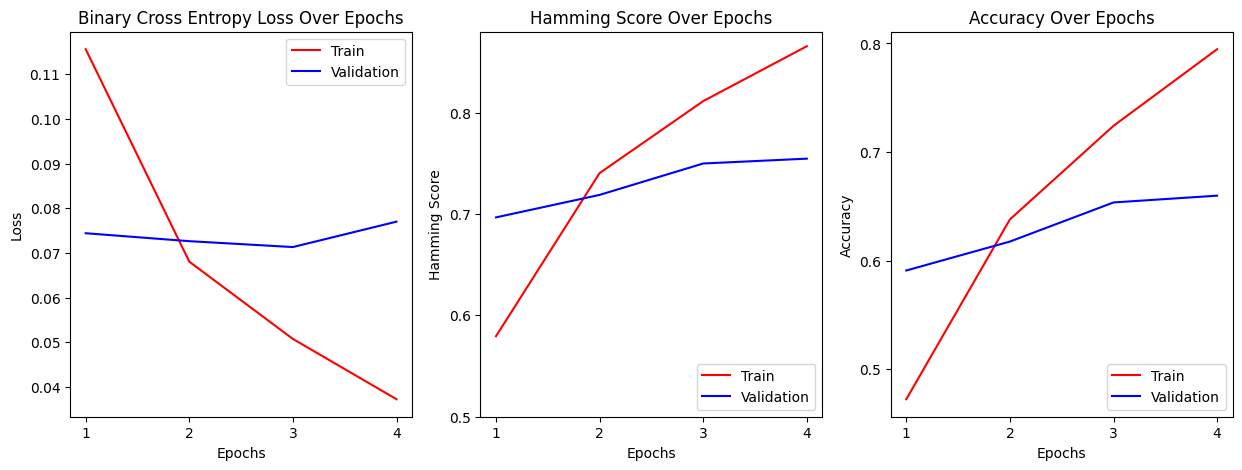

In [ ]:
# loading results
train_losses = loading_list(bert_results_filepath, 'train_losses_testing.json')
valid_losses = loading_list(bert_results_filepath, 'valid_losses_testing.json')
train_hamming = loading_list(bert_results_filepath, 'train_hamming_accuracy_testing.json')
valid_hamming = loading_list(bert_results_filepath, 'valid_hamming_accuracy_testing.json')
train_accuracy = loading_list(bert_results_filepath, 'train_accuracy_testing.json')
valid_accuracy = loading_list(bert_results_filepath, 'valid_accuracy_testing.json')


# creating copies of lists
train_accuracy_1 = train_accuracy.copy()
train_hamming_1 = train_hamming.copy()

# merging into single list to evaluate min and max accuracy
train_accuracy_1.extend(valid_accuracy)
train_hamming_1.extend(valid_hamming)
train_accuracy_1.extend(train_hamming_1)

# getting min, max accuracy and ticks for plotting
min_acc = round(min(train_accuracy_1), 1)
max_acc = round(max(train_accuracy_1), 1)
y_ticks = np.arange(min_acc, max_acc, step=0.1)
epochs_list = [i for i in range(1, len(valid_losses) + 1)]

# plotting losses over epochs
plt.figure(figsize=(15, 5))

# actual losses
plt.subplot(1, 3, 1)
plt.plot(epochs_list, train_losses, label="Train", color="red")
plt.plot(epochs_list, valid_losses, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.xticks(epochs_list)
plt.ylabel("Loss")
plt.title("Binary Cross Entropy Loss Over Epochs")
plt.legend()

# actual losses
plt.subplot(1, 3, 2)
plt.plot(epochs_list, train_hamming, label="Train", color="red")
plt.plot(epochs_list, valid_hamming, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.xticks(epochs_list)
plt.ylabel("Hamming Score")
plt.yticks(y_ticks)
plt.title("Hamming Score Over Epochs")
plt.legend(loc="lower right")

# actual losses
plt.subplot(1, 3, 3)
plt.plot(epochs_list, train_accuracy, label="Train", color="red")
plt.plot(epochs_list, valid_accuracy, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.xticks(epochs_list)
plt.ylabel("Accuracy")
plt.yticks(y_ticks)
plt.title("Accuracy Over Epochs")
plt.legend(loc="lower right")

plt.show()

## Loading Trained Model Parameters

In [ ]:
# getting best model number
best_model_no = valid_losses.index(min(valid_losses)) + 1

# loading best model
model = BERTClass(hidden_dim, len(cluster_numbers))
model.to(torch.device('cpu'))
model = loading_torch_model(model, bert_model_filepath, f'bert_epoch_{best_model_no}.pt')
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Applying Over Entire Validation Set

## Loss, Hamming Accuracy and Accuracy

In [ ]:
valid_loss, valid_preds, valid_targets = evaluate(valid_loader) # evaluate model over entire dataset using the best trained model

valid_preds_round = np.around(valid_preds) # rounding predictions
valid_hamming_acc = hamming_score(valid_targets, valid_preds_round) # validation hamming accuracy
valid_reg_acc = accuracy_score(valid_targets, valid_preds_round) # validation accuracy

# printing results
print(f'Validation Loss: {valid_loss}\n')
print(f'Validation Hamming Accuracy: {valid_hamming_acc}\n')
print(f'Validation Sklearn Accuracy: {valid_reg_acc}\n')


Evaluating...
Validation Loss: 0.07261539638508112

Validation Hamming Accuracy: 0.7188708732174253

Validation Sklearn Accuracy: 0.6175424887673374



In [ ]:
multilabel_pred = [" ".join(map(str, map(int, pred))) for pred in valid_preds_round] # merging multilabel into string
val_df["multilabel_pred"] = multilabel_pred # appending string predictions onto dataframe
saving_file(val_df, bert_results_filepath, 'bert_applied_multilabel_valid.csv')
val_df.head(2)

,text,sentences,cleaned_sentences,top_topics_list,top_topics_str,number_of_tags,label_-1,label_0,label_1,label_2,...,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,multilabel_pred
0,Made a transfer to a new payee via my thumb on...,",Name, postcode, account number, sort code, da...",name postcode account number sort code date bi...,"['account issues', 'fraudulent transactions']","account issues, fraudulent transactions",2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
1,Been with Starling Bank for nearly a year. The...,They are ok until there is an issue.,ok until there issue .,['customer_service'],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0


## Confusion Matrix

In [ ]:
valid_preds_2 = np.array([list(map(int, multilabel_str.split())) for multilabel_str in [multilabel for multilabel in val_df["multilabel_pred"]]]) # converts list of multilabel strings to multilabel array
valid_true = val_df[label_list].values

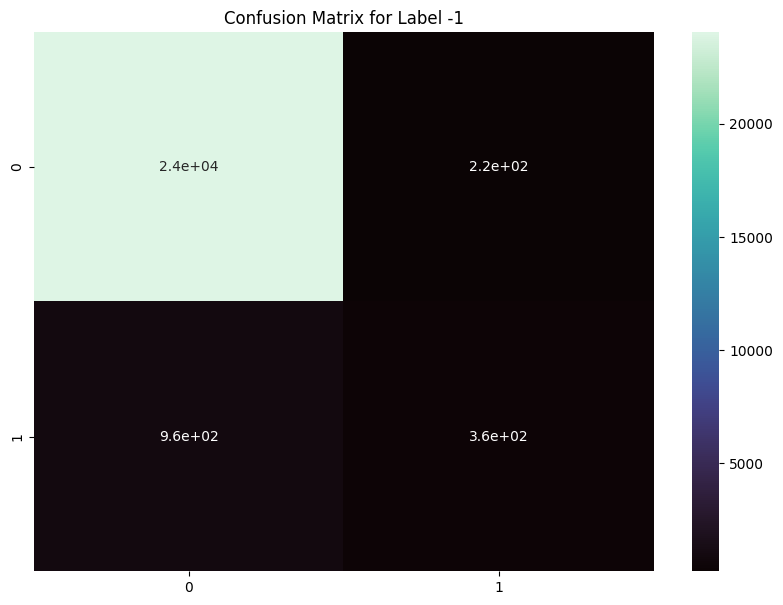

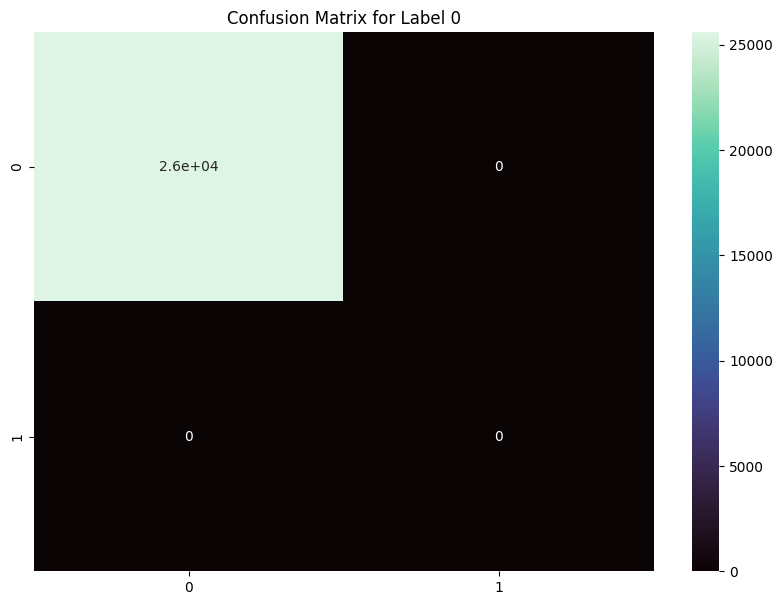

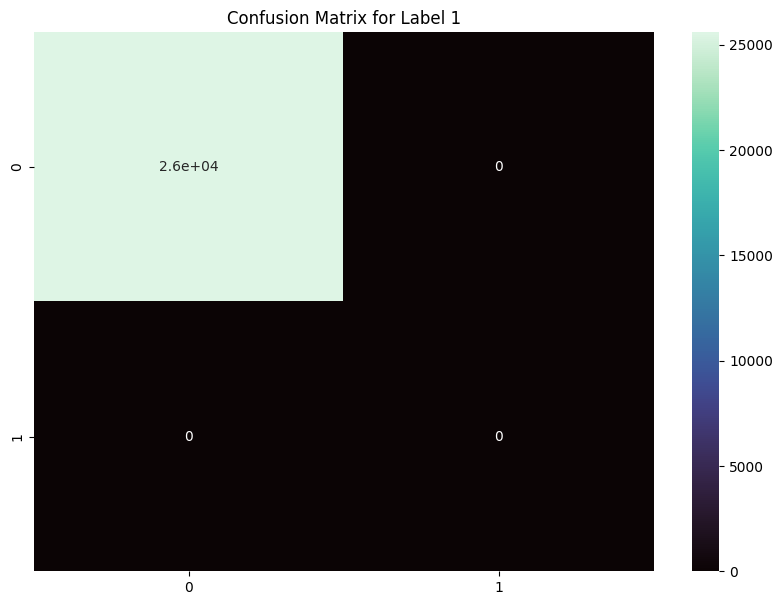

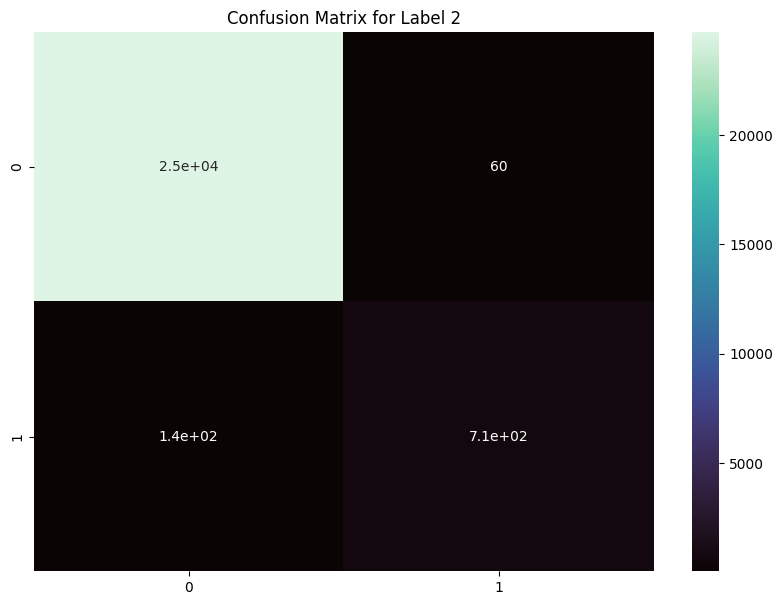

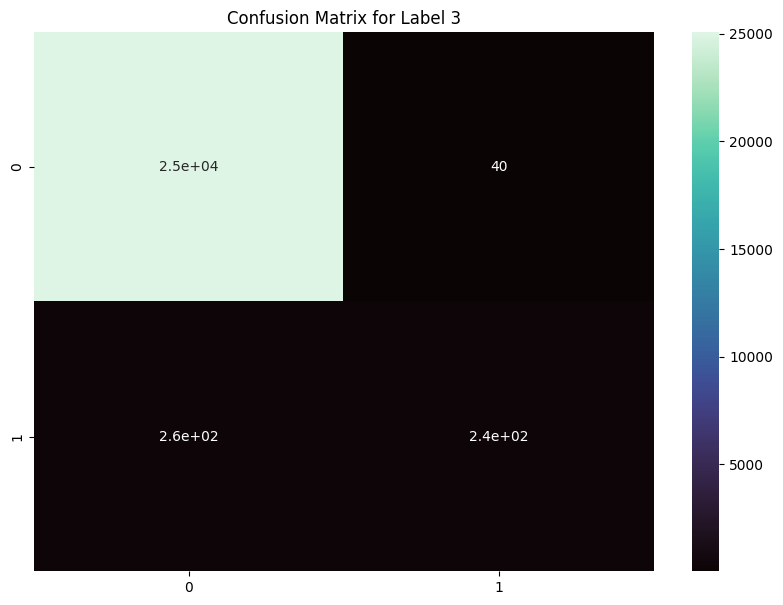

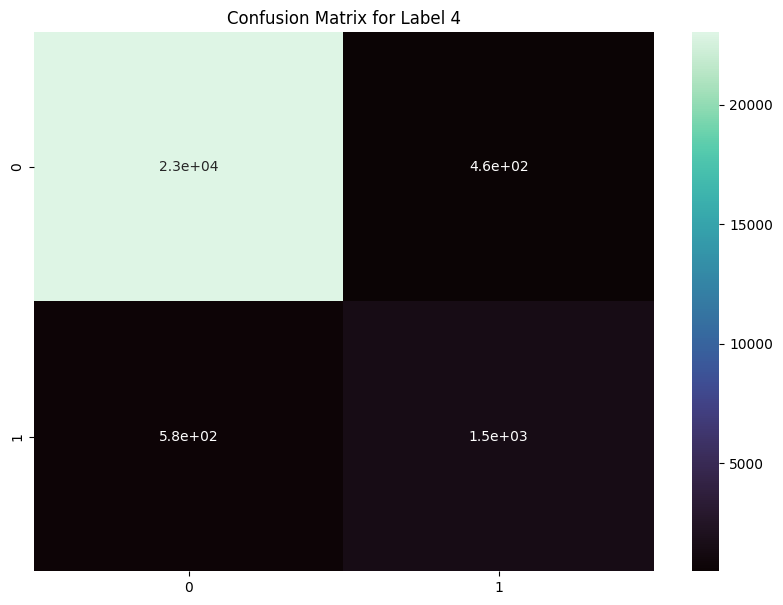

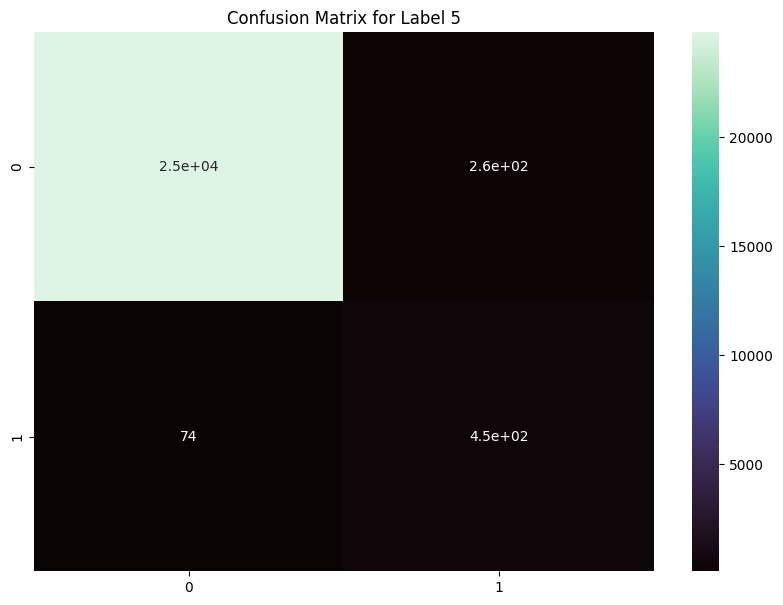

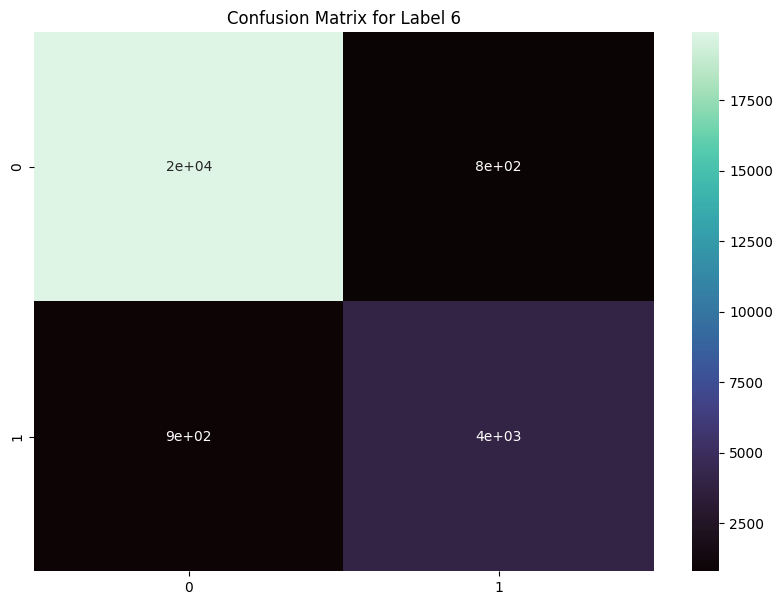

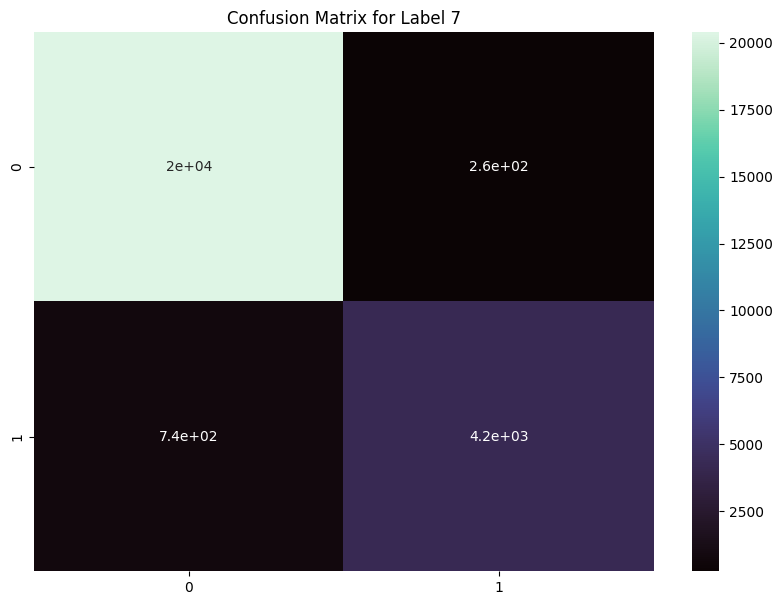

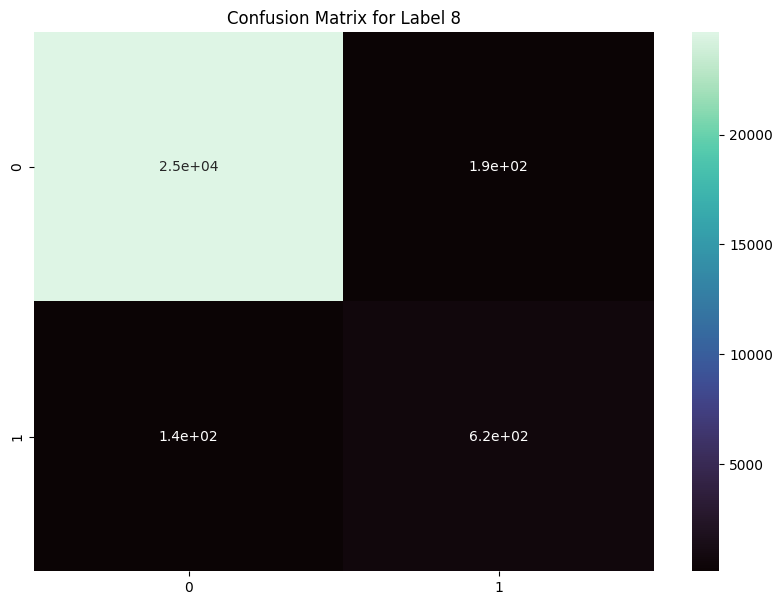

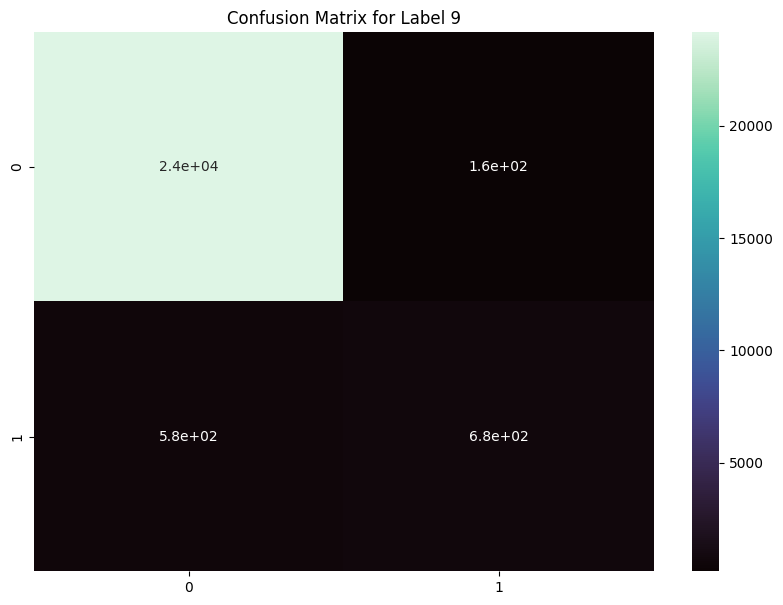

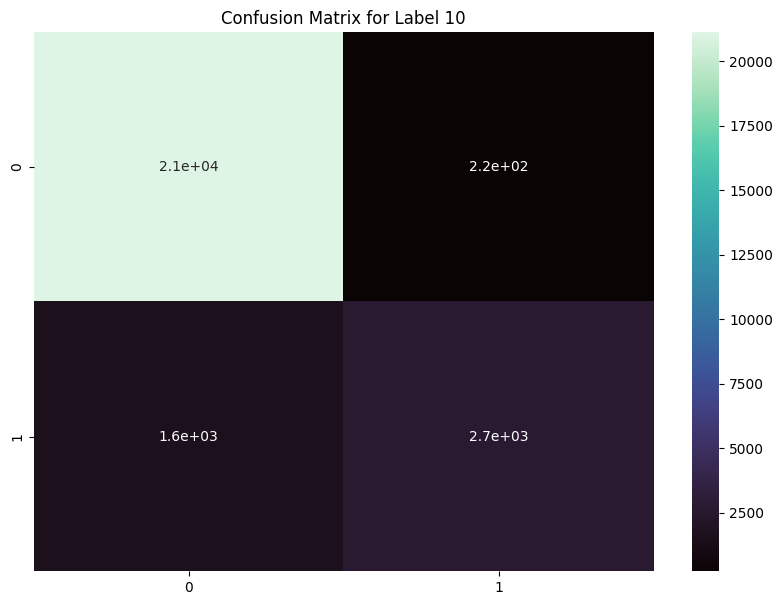

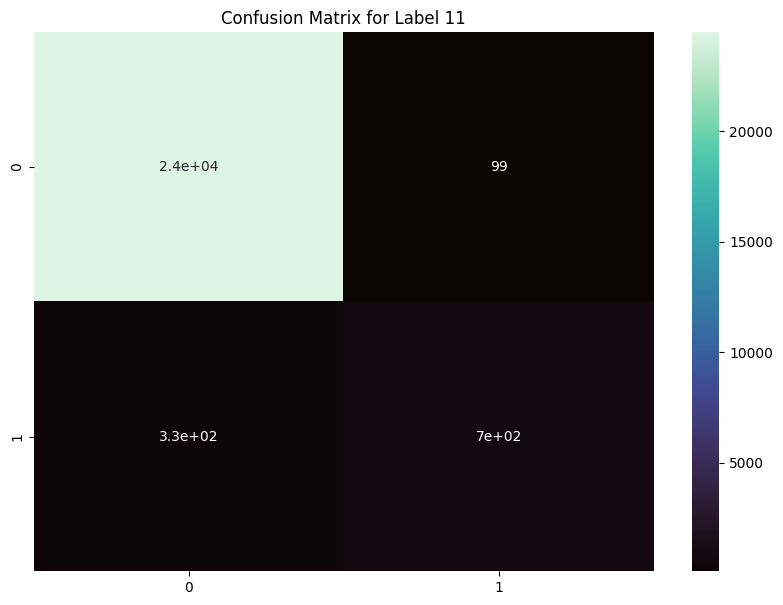

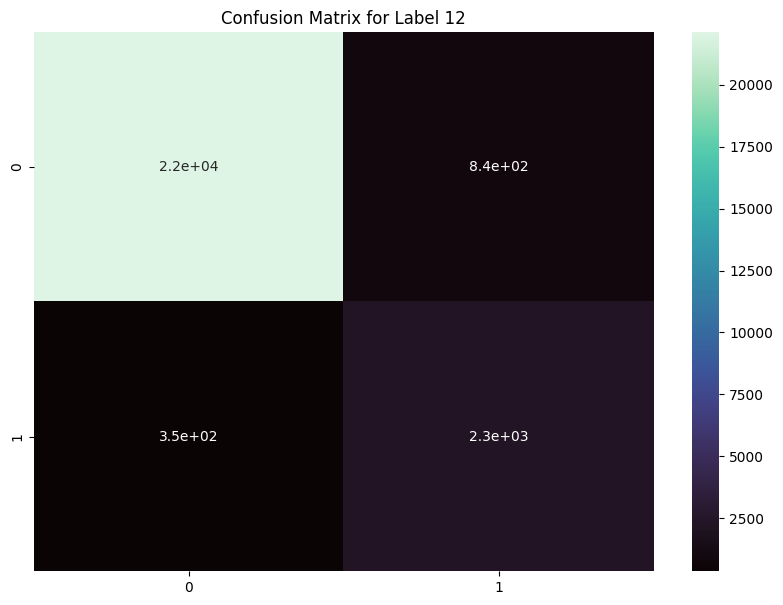

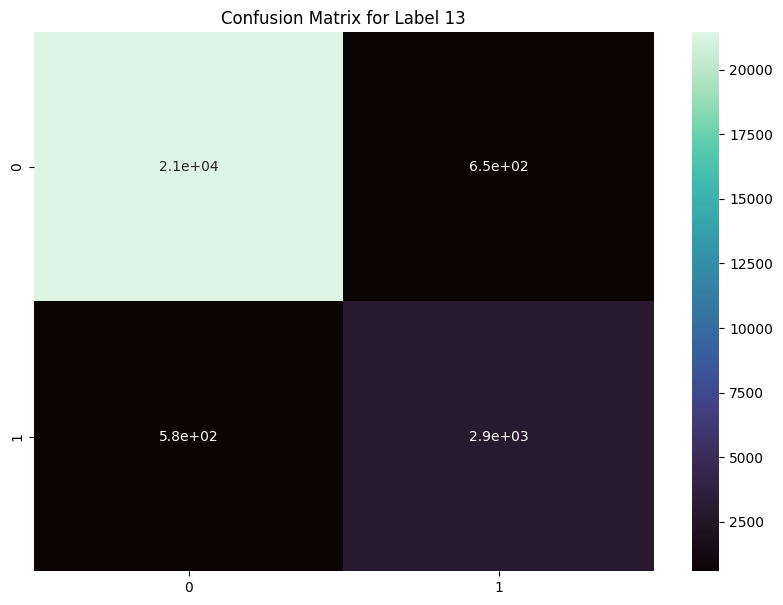

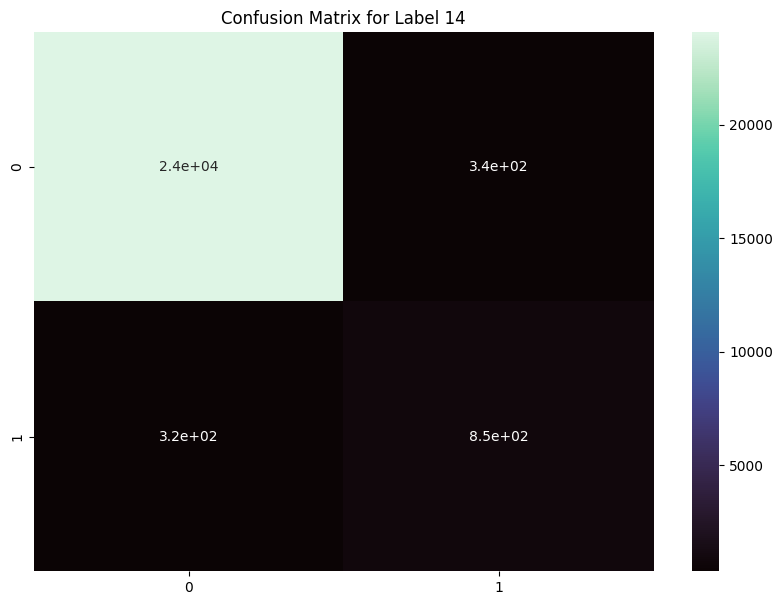

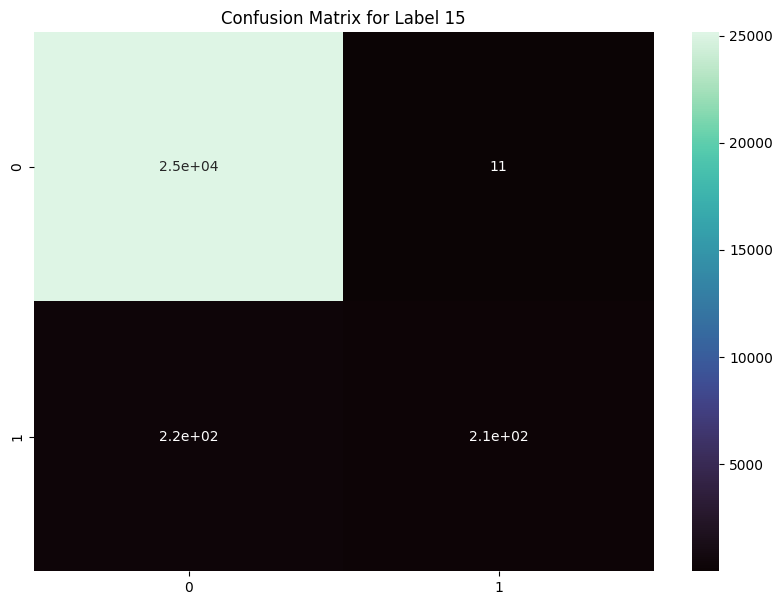

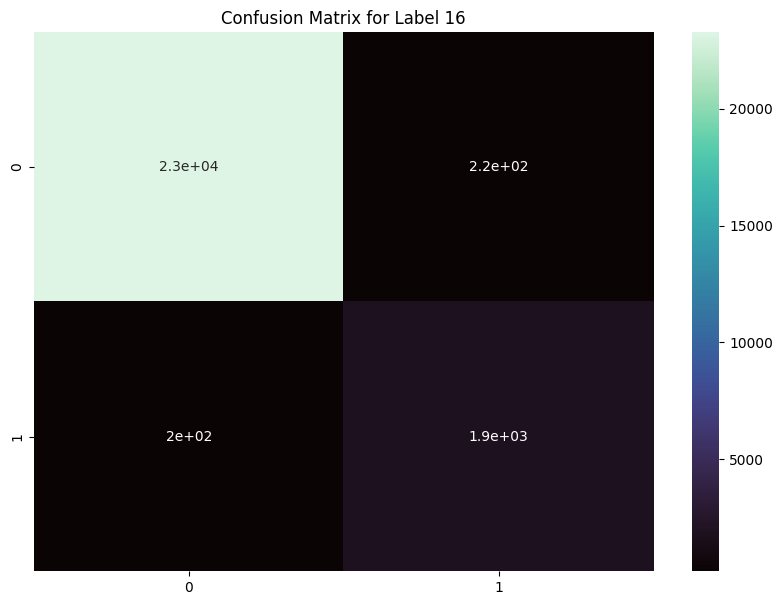

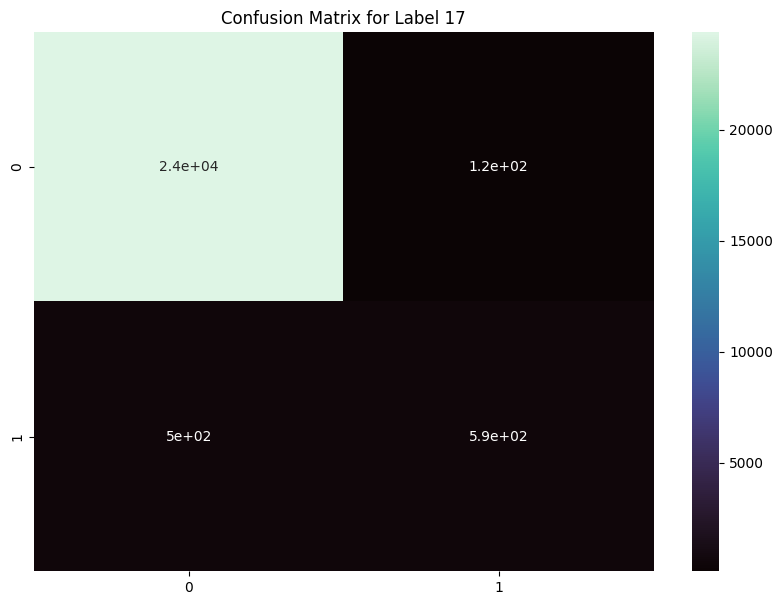

In [ ]:
cm = multilabel_confusion_matrix(valid_true, valid_preds_2)

for cluster_number in cluster_numbers: 
    plt.figure(figsize = (10,7))
    sn.heatmap(cm[cluster_number + 1], annot=True, cmap="mako")
    plt.title(f"Confusion Matrix for Label {cluster_number}")
    plt.show()

## Single Confusion Matrix

In [ ]:
val_df["multilabel_true"] = ""
for label in label_list:
    if label_list.index(label) != len(label_list) - 1: 
        val_df["multilabel_true"] += val_df[label].apply(lambda x: str(x)) + " "
    else:
        val_df["multilabel_true"] += val_df[label].apply(lambda x: str(x))
val_df

,text,sentences,cleaned_sentences,top_topics_list,top_topics_str,number_of_tags,label_-1,label_0,label_1,label_2,...,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,multilabel_pred,multilabel_true
0,Made a transfer to a new payee via my thumb on...,",Name, postcode, account number, sort code, da...",name postcode account number sort code date bi...,"['account issues', 'fraudulent transactions']","account issues, fraudulent transactions",2,0,0,0,0,...,0,0,1,0,0,0,0,0,0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
1,Been with Starling Bank for nearly a year. The...,They are ok until there is an issue.,ok until there issue .,['customer_service'],customer_service,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
2,Horrendous customer service treating me like a...,I asked him why did they block my card when th...,asked him why block text message security safe...,"['account issues', 'customer_service']","account issues, customer_service",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
3,Had a problem with one time passcodes and a re...,Will be closing my account as soon as possibl...,closing account soon possible rest family .,['account issues'],account issues,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
4,My partner need our bank statements for visa p...,My partner need our bank statements for visa p...,partner our statements visa purposes .,"['online payments', 'tedious paperwork (reques...","online payments, tedious paperwork (request of...",2,0,0,0,0,...,0,0,0,1,0,0,0,0,0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,"Terrible service! Opened a business account, a...","Opened a business account, after a month of op...",opened business account after month operating ...,['account issues'],account issues,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
25591,Awful. Do not use this bank. App works very we...,App works very well but there’s no support beh...,app works very well there support behind .,['app interface'],app interface,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
25592,My account was deactivated march 22nd 2022. Bu...,My account was deactivated march 22nd 2022.,account deactivated march 22nd 2022 .,['account issues'],account issues,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
25593,Do not use Revolut. The are the worst out ther...,READ ALL THE NEGATIVE REVIEWS IF YOU ARE STILL...,read negative reviews still doubt .,['noise'],noise,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [ ]:
true_combinations = list(set(val_df["multilabel_true"].values))
pred_combinations = list(set(val_df["multilabel_pred"].values))
true_combinations.sort()
pred_combinations.sort()

print(f"Number of multilabel combinations (True): {len(true_combinations)}\nNumber of multilabel combinations (Predicted): {len(pred_combinations)}")

y_true = val_df["multilabel_true"].values
y_valid = val_df["multilabel_pred"].values


# getting confusion matrix
new_cm = confusion_matrix(y_true, y_valid)

# dropping zero rows and columns
# columns with at least one non-zero
cols = new_cm.any(axis=0)

# rows with at least one non-zero
rows = new_cm.any(axis=1)

# boolean indexing
new_cm = new_cm[rows]

Number of multilabel combinations (True): 58
Number of multilabel combinations (Predicted): 105


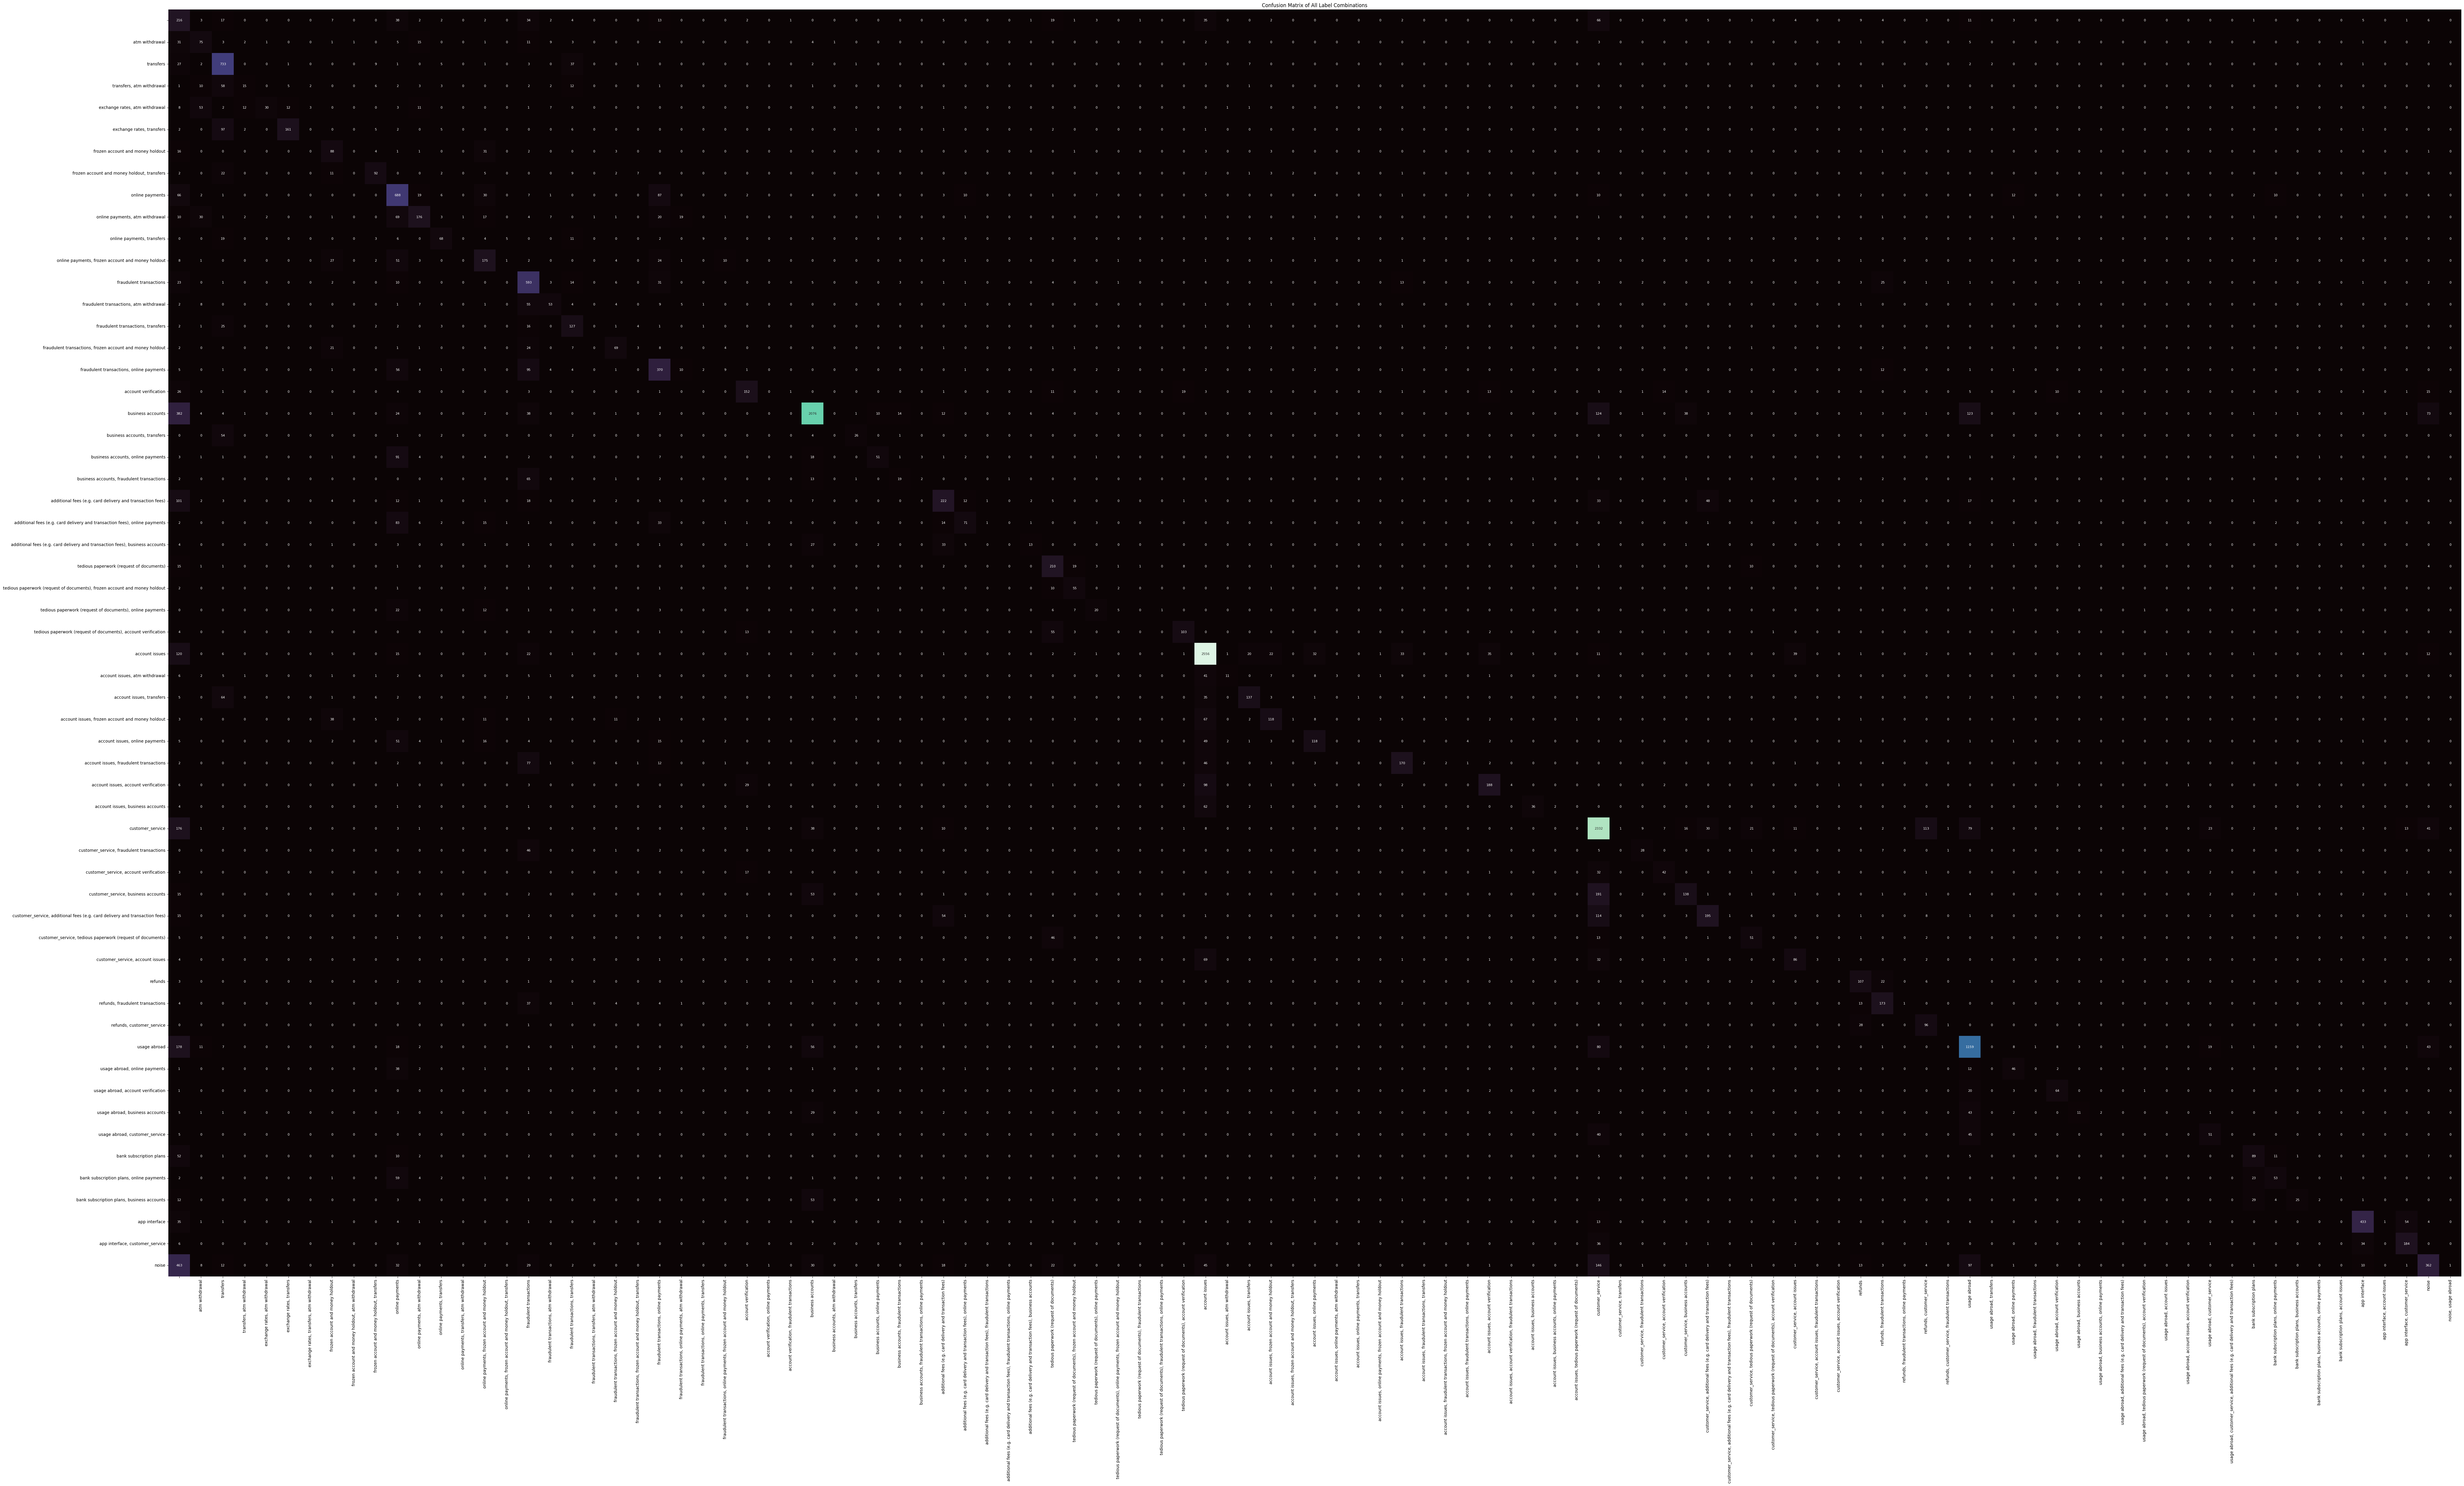

In [ ]:
# getting topic combinations
label_combination_topics_pred = [", ".join([topic_dict[i-1] for i in range(len(combi)) if int(combi[i]) == 1]) for combi in [combi_str.split(" ") for combi_str in pred_combinations]]
label_combination_topics_true = [", ".join([topic_dict[i-1] for i in range(len(combi)) if int(combi[i]) == 1]) for combi in [combi_str.split(" ") for combi_str in true_combinations]]

# plotting confusion matrix
plt.figure(figsize = (100, 100))
sn.heatmap(new_cm, annot=True, cmap="mako", cbar=False, xticklabels=label_combination_topics_pred, yticklabels=label_combination_topics_true, fmt='g', square=True, annot_kws={"fontsize":8})
plt.title(f"Confusion Matrix of All Label Combinations")
plt.show()

## Classification Report

In [ ]:
print(classification_report(valid_true, valid_preds_2))

              precision    recall  f1-score   support

           0       0.62      0.27      0.38      1324
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.92      0.84      0.88       841
           4       0.86      0.48      0.61       498
           5       0.76      0.72      0.74      2087
           6       0.64      0.86      0.73       527
           7       0.83      0.82      0.82      4881
           8       0.94      0.85      0.89      4944
           9       0.77      0.82      0.79       756
          10       0.81      0.54      0.65      1263
          11       0.92      0.64      0.75      4257
          12       0.88      0.68      0.77      1029
          13       0.73      0.87      0.79      2630
          14       0.82      0.83      0.83      3497
          15       0.71      0.73      0.72      1167
          16       0.95      0.48      0.64       431
          17       0.89    

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/py8_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/py8_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/py8_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/py8_nlp/lib/pyt

# Performance over testing

In [ ]:
# loading best model
best_model_no = valid_losses.index(min(valid_losses)) + 1
model = BERTClass(hidden_dim, len(cluster_numbers))
model.to(torch.device('cpu'))
model = loading_torch_model(model, bert_model_filepath, f'bert_epoch_{best_model_no}.pt')
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=learning_rate)

# Loading and wrapping test set
test_set = Dataset(test_df, tokenizer, max_len)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True) # testing set

test_loss, test_preds, test_targets = evaluate(test_loader) # evaluate model over test set using the best trained model

test_preds_round = np.around(test_preds) # rounding predictions
test_hamming_acc = hamming_score(test_targets, test_preds_round) # testing hamming accuracy
test_reg_acc = accuracy_score(test_targets, test_preds_round) # testing accuracy

# printing results
print(f'Testing Loss: {test_loss}\n')
print(f'Testing Hamming Accuracy: {test_hamming_acc}\n')
print(f'Testing Sklearn Accuracy: {test_reg_acc}\n')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Evaluating...
Testing Loss: 0.0680705893469534

Testing Hamming Accuracy: 0.7513024120441557

Testing Sklearn Accuracy: 0.6677300162944942

